## answers 09: a mixture of five

In [29]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats   as stats               # for stats.nbinom.logpmf()
import scipy.special as special             # for special.logsumexp()

%matplotlib inline

infile = "w09-data.tbl"

## 1. reproduce Wiggins' K-means result

I'll define some functions that I need for k-means, then a function that implements k-means, then I'll call it on Wiggins' data. While I'm defining these functions, I also have an eye toward things I need for parts (2) and (3) of the p-set.

I could read Wiggins' data file in with Pandas, I suppose, but I didn't. Here's a parsing function.

In [2]:
def read_data(infile):
    """
    Parse Wiggins' data file. 
    Returns (ctype, data, N, G, Q):
       ctype[i]:  cell type 0..Q-1 for each cell i (0..N-1)
       data[i,g]: mapped read counts for each cell i, for each gene g
       N:         number of cells (rows of data)
       G:         number of genes (columns of data)
       Q:         number of cell types (true/known clusters)
    """
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

I'll initialize my centroids to some sort of random guess. Here's one way to do it: throw random points into the space encompassed by the data.

I only initialize one centroid at a time, because I'll use this same function to reinitialize a centroid that loses all its data points in the iterations.

In [3]:
def initialize_centroid(rng, X):
    """
    Returns one random centroid position
    Input: rng :    random number generator
           X[i,g] : the actual data; we use this to determine the min/max in each dimension,
                    and we sample a random vector uniformly on each dimension within those bounds.
    """
    N, G   = np.shape(X)
    dmax   = np.amax(X, axis=0)
    dmin   = np.amin(X, axis=0)
    mu     = np.zeros(G)
    for g in range(G):
        mu[g] = np.exp(rng.uniform(np.log(dmin[g]), np.log(dmax[g])))  
    return mu

Most fundamentally, K-means depends on calculating the Euclidean distance between a current centroid and a data point. So here's a function for calculating my distance. In part (3) of the problem I'm going to calculate the distance in log(counts) space instead of (counts) space, using an option `in_logspace=True`.

In [4]:
def euclidean_dist(v1, v2, in_logspace=False):
    """
    Return the euclidean distance || v1 - v2 ||.
    If in_logspace is True, do || log(v1) - log(v2) || instead.
    """
    d = 0.
    for i in range(len(v1)):
        if in_logspace:
            d += (np.log(v1[i]) - np.log(v2[i]))**2
        else:
            d += (v1[i] - v2[i])**2
    return np.sqrt(d)

At each K-means assignment step, we identify the current closest centroid for each data point. I'll make a function for that. It also has the `in_logspace` option, just to pass it on to `euclidean_dist()`.

In [5]:
def closest_centroid(x, centroids, in_logspace=False):
    """
    Input:
       centroids[k,g] : the current centroid positions, for centroids k=0..K-1, dimensions/genes g=0..G-1
       x[g]:            one data point
       in_logspace:     if True, do distance calculations in log(counts), not (counts)
    Returns best_k, best_dist:
       best_k         : index of the best centroid (0..K-1)
       best_d         : distance to the best centroid
    """
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = euclidean_dist(x, centroids[0], in_logspace)
    for k in range(1,K):
        dist = euclidean_dist(x, centroids[k], in_logspace)
        if dist < best_dist:
            best_k    = k
            best_dist = dist
    return best_k, best_dist


Then I use closest_centroid() to implement the k-means assignment step:

In [6]:
def assign_kmeans(X, centroids, in_logspace=False):
    """
    Input:
       X[i,g] are the data point
       centroids[k] are the current centroid positions
       in_logspace: if True, do distance calculations in logspace
    Return assignments, totdist:
       assignments[i] assign each data point i to a cluster k
       tot_sqdist is the total squared distance, the k-means objective function
    """
    K, dim      = np.shape(centroids)
    N           = len(X)
    assignments = np.zeros(N).astype(int)
    tot_sqdist  = 0
    for i,x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids, in_logspace)
        tot_sqdist += di**2
    return assignments, tot_sqdist


Then in the K-means update step, I calculate new centroid positions, given assignments of data points to centroids.

An important detail: it's possible for a centroid to die, receiving no assigned points. I have to be careful to catch this case (and avoid division by zero errors).

In [7]:
def update_kmeans(rng, X, assignments, K):
    """
    Input:
      rng : random number generator (needed for any random reinit of a centroid)
      X[i,g] are the data points; i=0..N-1,  g=0..G-1
      assignments[i] : which centroid (0..K-1) each point has just been assigned to
      K : how many centroids there are
    Returns:
      centroids[k,g] : updated centroid positions
      pk[k]          : frequency of using component k: how many points were assigned to it, normalized.
    """
    N, G    = np.shape(X)              
    
    centroids = np.zeros((K,G))        
    counts    = np.zeros(K)
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            centroids[assignments[i], g] += X[i][g]

    for k in range(K):
        if counts[k] > 0:                                      # In a K-means implementation we have to watch out for the case
            centroids[k] = np.divide(centroids[k], counts[k])  # where a centroid gets no assigned points. Avoid dividing by zero.
        else:                                                  # One strategy is to leave the centroid unchanged. 
            centroids[k] = initialize_centroid(rng, X)         # Here, instead, we reinitialize it randomly.

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    return centroids, counts

I need to detect when the iterative algorithm has converged. The simplest thing to look at is whether any assignments were changed in the current iteration. If not, I've reached a stable answer.

In [8]:
def diff_assignments(a1, a2):
    """
    Returns the number of assignments that differ between <a1> and <a2>,
    where these are, e.g., a1[i] = 0..K-1, a cluster assignment for each cell i.
    """
    N     = len(a1)
    ndiff = 0
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
    return ndiff

Finally I'm ready to implement the k-means algorithm itself.

I have the routine return tot_sqdist, the total squared Euclidean distance for data points to their assigned centroids. K-means is a local optimizer: I'm going to have to run it many times and choose a "best" answer. tot_sqdist is our measure of "best". I can compare different runs of K-means using this as an objective function, looking for a run that gives us the minimum squared distance.

In [9]:
def kmeans(rng, X, K, T=np.zeros(0), in_logspace=False):
    """
    Input:
       rng:     random number generator
       X[i,g]:  data points i=0..N-1, each of which is a vector w/ g=0..G-1
       K     :  how many clusters to fit
       T[i]  :  OPTIONAL: known/true cluster assignments; initialize centroids on their true positions (debugging)
       in_logspace: OPTIONAL: True to do distance calculations in log space
    Return (kp, centroids, assignments, totdist, n_iterations):
       kp[k]          :  probability mass (# of data points) assigned to component k
       centroids[k,g] : locations of each cluster centroid
       assignments[i] : which centroid 0..K-1 that each data point i=0..N-1 is assigned to
       tot_sqdist     : total squared Euclidean distance for this k-means solution.
       n_iterations   : how many iterations the algorithm took
    """
    N, G = np.shape(X)
    
    if len(T) > 0:
        centroids, qp = update_kmeans(X, T, K)
    else:
        centroids = np.zeros((K,G))
        for k in range(K):
            centroids[k] = initialize_centroid(rng, X)
    
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids, in_logspace)
        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0: 
                break
        centroids, kp   = update_kmeans(rng, X, assignments, K)
        old_assignments = assignments
        iteration      += 1

    kp = np.zeros(K)
    for i in range(N):
        kp[assignments[i]] += 1
    kp = np.divide(kp, N)

    return kp, centroids, assignments, tot_sqdist, iteration

Almost ready - now I'll define a function that uses matplotlib to visualize the clustering.

I'm going to allow this function to take an optional argument `<T>`, the true assignments, to produce a slightly enhanced visualization that compares a K-means clustering to the known answer. Alas, this frill forces me to do one extra step. The order of the centroids assigned by K-means is arbitrary. Even if I found the exact same answer as the true assignments, the order of the clusters is permuted. So I define a function `correspondence()` that tries to find an unambiguous mapping between the true and K-means clusterings. For a bad clustering, this can fail, so it returns `is_mapped` for whether it succeeds or not.

In [10]:
def correspondence(T, C):
    """
    Try to establish a correspondence between the true assignments T[i] and a K-means assignment C[i],
    so we can compare. The problem is that the order of the centroids K is arbitrary, so we can't
    do this comparison directly. Look for an order that is unambiguously best.
    
    If we can find one, set <is_mapped> True, and map[qt] = k is the index in C that corresponds to true set <qt>.
    
    Return is_mapped, map.
    """
    N  = len(T)
    Q  = np.max(T) + 1
    assert len(C)        == N
    # assert np.max(C) + 1 == Q    # This is not necessarily true! Centroid Q-1 might have been assigned to no points.

    A = np.zeros((Q,Q)).astype(int)
    for i in range(N):
        A[ T[i], C[i] ] += 1

    map = np.zeros(Q).astype(int)
    for qt in range(Q):
        map[ np.argmax(A[qt]) ] = qt
    
    if len(set(map)) == Q:
        is_mapped = True
    else:
        is_mapped = False
    return is_mapped, map


And now the visualization.

In [11]:
def visualize_data(data, centroids, C, T=np.zeros(0), outfile=None):
    N, G  = np.shape(data)
    Q, G2 = np.shape(centroids)
    assert G == G2
    assert len(C) == N

    if len(T) > 0:
        is_mapped, map = correspondence(T, C)
    else:
        is_mapped = False
        map       = None

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        if is_mapped:
            edgecolor = colormap[ map[C[i]]]
            if map[C[i]] == T[i]:   # correct assignment
                fillcolor = 'w'
                shape     = 'o'
            else:                   # incorrect assignment
                fillcolor = colormap[ T[i]]
                shape     = 's'
        else:
            edgecolor = colormap[ C[i]]
            fillcolor = 'w'
            shape     = 'o'

        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(centroids[q,0], centroids[q,1], '*k', ms=10)

    ax.set_xlabel('defA (counts)')
    ax.set_ylabel('kilA (counts)')

    if outfile:
        fig.savefig(outfile)

Finally!

Now I'll make sure it runs.

iterations = 16
0   0.6080    20.4424    18.5674
1   0.1160   112.3966   104.1121
2   0.0400    36.8000   188.3250
3   0.1390    17.9281    89.1223
4   0.0970   110.0000    12.1340
final totdist = 974869.2


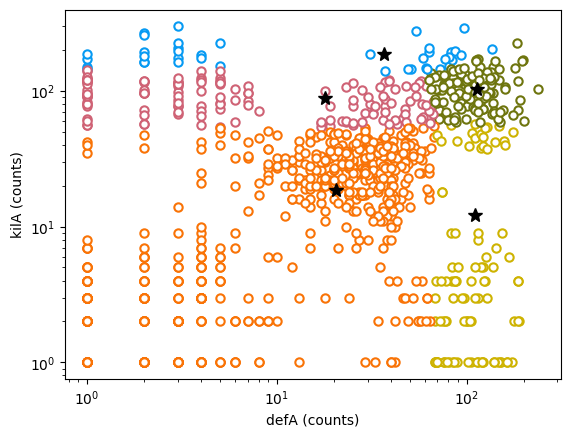

In [12]:
rng = np.random.default_rng(20241105)    # fixed RNG seed for reproducibility

ctype, data, N, G, Q                           = read_data(infile)
kp, centroids, assignments, tot_sqdist, n_iter = kmeans(rng, data, Q)
print('iterations = {}'.format(n_iter))
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, kp[q], centroids[q,0], centroids[q,1]))
print("final totdist = {0:.1f}".format(tot_sqdist))
visualize_data(data, centroids, assignments, T=ctype)


Here's a cheapo strategy for running K-means many times to identify a best solution, and to be able to reproduce that solution at will: we'll take advantage of being able to create a NumPy random number generator with a fixed seed.

In [13]:
results = []
for run in range(20):
    rng_f = np.random.default_rng(run)   # use the run number as the fixed seed
    kp, centroids, assignments, tot_sqdist, n_iter = kmeans(rng, data, Q)
    results.append( (run, kp, centroids, assignments, tot_sqdist, n_iter) )


In [14]:
results.sort(key = lambda x:x[4])
for r in results:
    run, n_iter, tot_sqdist = r[0], r[5], r[4]
    print('{:2d} {:4d} {:10.2f}'.format(run, n_iter, tot_sqdist))

 3   14  969263.03
 0   47  975899.83
 5   39  975899.83
11   42  975899.83
13   38  975899.83
15   40  975899.83
16   19  975899.83
 4   33  976013.28
 2   22  976056.49
 8   15  976056.49
 9   13  976056.49
12   16  976092.34
18   11  976092.34
19   19  976166.23
 1    9  978675.92
10    7  979280.28
 7   20  982971.99
14   17  987584.98
17   21  987584.98
 6   13  988654.62


Now the best run is sorted to `results[0]`. Visualize it.

0   0.1470    21.4490    85.9388
1   0.1020   115.7843   111.9118
2   0.0410    29.1220   185.2439
3   0.1100   108.2364    17.6000
4   0.6000    20.0633    18.1417


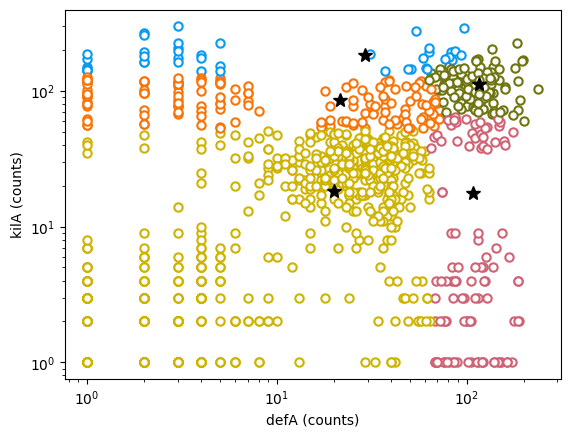

In [15]:
kp, centroids, assignments = results[0][1], results[0][2], results[0][3]
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, kp[q], centroids[q,0], centroids[q,1]))
visualize_data(data, centroids, assignments, T=ctype)



Close enough. I'll call that a reproduction of Wiggins' result. I'm having the same trouble that he did. K-means is not finding the obvious clusters in the data, even with 20 runs.

## 2. mixture negative binomial fitting

Now I'll use the same skeleton, and some of the same functions, to implement a mixture negative binomial model, and fit it iteratively with expectation maximization. 


I need to be able to calculate $\log P(x \mid \mu, \phi)$, the log probability of one data point given known NB parameters. The trick here is the change of variables to match what SciPy thinks the NB is, as we talked about in class and the lecture notes.

In [16]:
def logpmf_nb(x, mu, phi):
    p = 1 / (1 + mu * phi)
    n = 1 / phi
    return stats.nbinom.logpmf(x, n, p)

The expectation step corresponds to the k-means assignment step. Instead of making a hard assignment of each data point to one and only one cluster, I calculate a posterior probability $P(q \mid x, \theta)$ that the point belongs to component $q$, given our current mixture model $\theta$. The parameters of the current mixture model $\theta$ are passed around as three arrays: $\mu_q$, $\phi_q$, and `mixq[q]`.

In [17]:
def expectation_mixnb(X, mu, phi, mixq):
    """
    Input:
       X[i,g] are the data points.
       mu[q]  are the mean (mu) NB parameters, for each component q
       phi[q] are the dispersion (phi) NB parameters, for each component q
       mixq[q] are the mixture coefficients, the "prior" probability P(q) of each component
    Return nll, pp:
       nll     negative log likelihood of the current model
       pp[i,q] posterior probability that data point i belongs to component q   
    """
    N, G   = np.shape(X)
    Q, G2  = np.shape(mu)
    Q3     = len(mixq)
    assert G2 == G
    assert Q3 == Q

    pp  = np.zeros((N, Q))   # pp[i][k] = P(C=k \mid x_i)
    nll = 0
    for i in range(N):
        for q in range(Q):
            pp[i][q] = np.log(mixq[q])
            for g in range(G):
                pp[i][q] += logpmf_nb(X[i][g], mu[q][g], phi) 
        Z     = special.logsumexp(pp[i])   # Z = \log \sum_q P(X_i, q)  = \log P(X_i)
        nll  -= Z
        pp[i] = np.subtract(pp[i], Z)
        pp[i] = np.exp(pp[i])
    return nll, pp

The maximization step corresponds to the k-means update step. Instead of just calculating the centroid of the points assigned to each cluster, I estimate new maximum likelihood parameters for the mixture model, given posterior probabilities of how data points are assigned to the components.

The pset says that I can assume a common dispersion $\phi = 0.2$ so I don't reestimate the $\phi_q$, only the $\mu_q$ and the mixture coefficients `mix[q]`. The reestimated $\mu_q$ are just the posterior weighted means.

In [18]:
def maximization_mixnb(rng, X, pp):
    N,  G   = np.shape(X)
    N2, Q   = np.shape(pp)
    assert N == N2
    
    counts = np.sum(pp, axis=0)   # now counts[q=0..Q-1] are expected counts per component
    
    # Count data points i into mu[q=0..Q-1], proportional to pp[i][q]
    mu = np.zeros((Q,G))
    for i in range(N):
        for q in range(Q):
            for g in range(G):
                mu[q,g] += pp[i,q] * X[i,g]

    for q in range(Q):
        if counts[q] > 0:
            for g in range(G):
                mu[q,g] = mu[q,g] / counts[q]
        else:                               # it's harder to get counts[q] of literally zero now, but it can still happen.
            mu[q]     = initialize_centroid(rng, X)
            counts[q] = N / Q               # arbitrary reinitialization hack
            print("REINITIALIZED component ", q) # warn if we do it.

    mixq = np.divide(counts, N)
    return mixq, mu

I need an appropriate convergence test. We could use the total log likelihood of the data, or we could use the change in the parameters. Here I'll look at the change in the parameters $\mu_q$.

In [19]:
def difference_in_mu(mu, oldmu):
    Q, G  = np.shape(mu)
    Q2,G2 = np.shape(oldmu)
    assert Q == Q2
    assert G == G2

    delta = np.sum(np.fabs(np.subtract(mu, oldmu)))
    delta = delta / (Q*G)
    return delta

Now I can put those pieces together into an iterative EM routine for fitting a mixture NB to the data.

As in k-means, I allow an option where we can pass the true cluster assignments `T[i]` to initialize our components there. This is useful in debugging. If I start from the true answer, the algorithm should stably stay (near) there and more or less immediately converge.


In [20]:
def fit_mixnb(rng, X, Q, phi, T=np.zeros(0)):
    N, G   = np.shape(X)

    # initial guesses
    if len(T) > 0:
        mu, mixq = update_kmeans(X, T, K)  # we're using the k-means update to initialize at the true clusters (debugging)
    else:
        mu = np.zeros((Q,G))
        for q in range(Q):
            mu[q] = initialize_centroid(rng, X)
            mixq  = np.full(Q, 1.0/Q)

    iteration = 0
    while True:
        nll, pp  = expectation_mixnb(X, mu, phi, mixq)        
        oldmu    = mu.copy()
        mixq, mu = maximization_mixnb(rng, X, pp)
        delta    = difference_in_mu(mu, oldmu)
        iteration += 1
#        print("iteration {0}  nll {1:.1f}  delta {2:.3f}".format(iteration, nll, delta))
        if delta < 1.0: break
              
    nll, pp  = expectation_mixnb(X, mu, phi, mixq)
    assignments = np.zeros(N).astype(int)
    for i in range(N):
        assignments[i] = np.argmax(pp[i])

    return mixq, mu, assignments, nll, iteration

Does it work? (You can uncomment a print statement in `fit_mixnb` to see some output about how each iteration is doing.)

0   0.2258    89.5361    94.7780
1   0.1193     3.2222   103.8981
2   0.1381     3.0629     3.4866
3   0.4462    42.2193    22.4613
4   0.0706     3.4202     2.3051
final NLL = 9339.5
iterations = 5


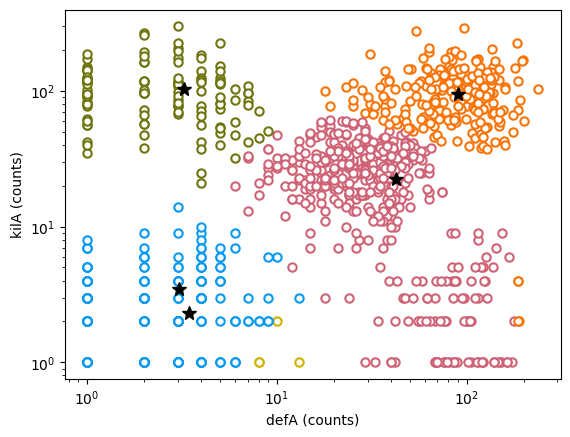

In [21]:
phi = 0.2
rng = np.random.default_rng(1)
mixq, mu, assignments, nll, n_iter = fit_mixnb(rng, data, Q, phi)

for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, mixq[q], mu[q,0], mu[q,1]))
print("final NLL = {0:.1f}".format(nll))
print("iterations = {}".format(n_iter))
visualize_data(data, mu, assignments, T=ctype)

Meh. Sort of. Still prone to local optima though!

I still have to run a bunch of times, and take the best. The total negative log likelihood of each 'optimal' model fit is a good statistic to compare; smaller is better. This takes a while, and warms up the fans on my laptop:

In [22]:
results = []
for run in range(20):
    rng_f = np.random.default_rng(run)   # use the run number as the fixed seed
    mixq, mu, assignments, nll, n_iter = fit_mixnb(rng, data, Q, phi)
    results.append( (run, mixq, mu, assignments, nll, n_iter) )


In [23]:
results.sort(key = lambda x:x[4])
for r in results:
    run, n_iter, nll = r[0], r[5], r[4]
    print('{:2d} {:4d} {:10.1f}'.format(run, n_iter, nll))

 7   12     8845.7
 3    7     8845.7
19   14     8845.8
 1    6     8846.0
 2    6     8846.1
 4    5     8846.1
16    7     8846.2
 5    4     8846.2
17    5     8847.4
10    8     8847.6
15   16     9336.7
14   10     9338.4
18    8     9339.7
12    5     9339.9
 0    9     9342.5
13    3     9408.7
11    8     9437.3
 9    7     9439.6
 8    3     9474.0
 6    4     9552.4


A bunch of solutions around 8846 nats. I'll look at the best one, run 1:

0   0.2016    93.8422   100.2000
1   0.3798    28.9124    29.5781
2   0.2075     3.1596     3.0560
3   0.0987    93.2416     2.8033
4   0.1123     2.9897   107.8813


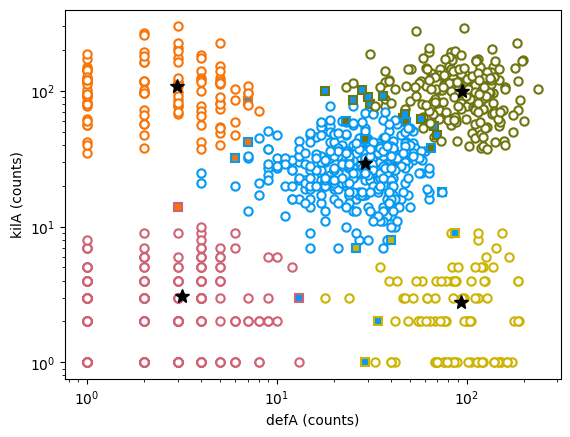

In [24]:
mixq, mu, assignments = results[0][1], results[0][2], results[0][3]
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, mixq[q], mu[q,0], mu[q,1]))
visualize_data(data, mu, assignments, T=ctype)

Pretty much nailed it. (The positions of the clusters, anyway. There's a little bit of misassignment of points along the boundaries between clusters, which we should expect, because the clusters slightly overlap.)

The fitted mean expression levels of defA and kilA for each component are in the table above the figure, with their relative proportions.

The true answer was:

```
  0  0.1     3   100
  1  0.2   100   100
  2  0.4    30    30
  3  0.2     3     3 
  4  0.1   100     3 
```

which you can see in the best fit, with the components permuted.

## 3. find a simple fix for k-means

k-means implicitly assumes clusters shaped as spherical Gaussians, with equal variance, with uniform mass (each cluster has about the same number of points assigned to it). We can't do much about the equal variance and uniform mass assumptions, unless we move away from k-means to fitting an explicit mixture model like we just did. But we do have freedom to change the basis of the space that we're calculating Euclidean distances in, and this choice can have big effects on k-means.

For instance, here the fact that Wiggins and I have been plotting _defA_ vs _kilA_ counts on log-log plots is a big clue. These data look like nice clusters in _log_ space, not in their raw counts. 

I left an option `in_logspace` in my k-means implementation; now I'll use it. 

In [25]:
results = []
for run in range(20):
    rng_f = np.random.default_rng(run)   # use the run number as the fixed seed
    kp, centroids, assignments, tot_sqdist, n_iter = kmeans(rng, data, Q, in_logspace=True)
    results.append( (run, kp, centroids, assignments, tot_sqdist, n_iter) )


In [26]:
results.sort(key = lambda x:x[4])
for r in results:
    run, n_iter, tot_sqdist = r[0], r[5], r[4]
    print('{:2d} {:4d} {:10.2f}'.format(run, n_iter, tot_sqdist))

 3    8     638.10
 4   11     638.10
 5    5     638.10
 6    7     638.10
 8    6     638.10
10    8     638.10
14    7     638.10
16   10     638.10
 0   33     638.61
 2    8     638.61
 9   24     638.61
11   11     638.61
12    7     638.61
13   14     638.61
17    6     638.61
18    6     638.61
19    6     638.61
 7   34    2004.31
 1   15    2020.35
15   25    2023.60


Looks like 17/20 of the runs converged to similar answers. I'll look at the best one:

0   0.2110     3.2370     3.1469
1   0.1200     3.1917   103.5917
2   0.3810    29.5801    31.3071
3   0.1030    91.2136     2.9417
4   0.1850    99.2973   103.4486


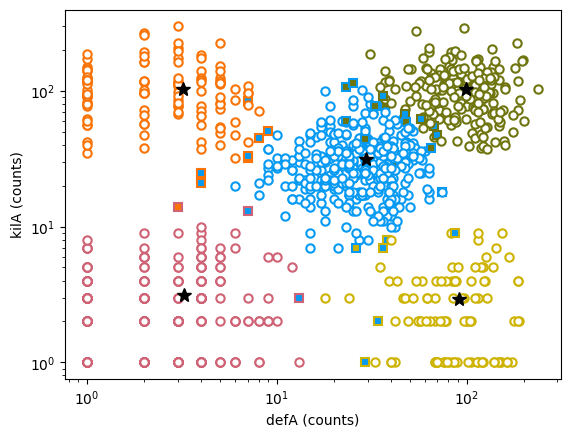

In [27]:
kp, centroids, assignments = results[0][1], results[0][2], results[0][3]
for q in range(Q):
    print("{0:<3d} {1:6.4f} {2:10.4f} {3:10.4f}".format(q, kp[q], centroids[q,0], centroids[q,1]))
visualize_data(data, centroids, assignments, T=ctype)


Yup, that did it. k-means works fine on these data so long as I work in log(counts) space.

That's actually a pretty common trick with RNA-seq count data. Empirically, mapped read count distributions are reasonably fit to either a lognormal or a negative binomial. If we log-transform count data that's distributed lognormal, now the log-counts are distributed normally, and now methods that either implicitly or explicitly assume normally-distributed errors (deviations from expected means; "residuals") will work much better.

### closing formalities

In [28]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib


Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

jupyter   : 1.0.0
numpy     : 2.1.0
matplotlib: 3.9.2

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

